In [18]:
import wandb
import torch
import yaml
from barlow_twins import (
    ResNetBarlow
)
from torch.utils.data import DataLoader
from torchvision.transforms import Compose
from tqdm import tqdm
import os
import pandas as pd
from ecallisto_dataset import (
    EcallistoDatasetBinary,
    custom_resize,
    remove_background,
)


In [24]:
import wandb
import os

def download_file(run, filename, download_dir='.', replace=True):
    """
    Downloads a specified file from a wandb run.

    Args:
        run (wandb.sdk.wandb_run.Run): The wandb run object.
        filename (str): The name of the file to download.
        download_dir (str, optional): Directory to download the file to. Defaults to current directory.
        replace (bool, optional): Whether to replace the file if it already exists. Defaults to True.

    Returns:
        str: The path to the downloaded file.
    """
    # Retrieve the file object from the run
    file = run.file(filename)
    if file is None:
        print(f"File '{filename}' not found in the run.")
        return None
    
    # Ensure the download directory exists
    os.makedirs(download_dir, exist_ok=True)
    
    # Download the file
    downloaded_path = file.download(root=download_dir, replace=replace)
    print(f"File '{filename}' has been downloaded successfully to '{downloaded_path}'.")
    return downloaded_path



# Initialize the wandb API
api = wandb.Api()

# Define your run path in the format 'entity/project/run_id'
# Replace with your actual run path
run_path = "vincenzo-timmel/FlareSense-Barlow-Twins/9f1qrj5k"  # Removed 'runs/' from the path

run = api.run(run_path)

# List of filenames to download
files_to_download = [
    "val_f1-epoch=01-step=07616-val_f1=0.127.ckpt",
    "config.yaml"
]

# Optional: Specify a custom download directory
download_directory = "./downloaded_files"

# Download each file using the wrapper function
for filename in files_to_download:
    download_file(run, filename, download_dir=download_directory)

File 'val_f1-epoch=01-step=07616-val_f1=0.127.ckpt' has been downloaded successfully to '<_io.TextIOWrapper name='./downloaded_files/val_f1-epoch=01-step=07616-val_f1=0.127.ckpt' mode='r' encoding='UTF-8'>'.
File 'config.yaml' has been downloaded successfully to '<_io.TextIOWrapper name='./downloaded_files/config.yaml' mode='r' encoding='UTF-8'>'.


In [29]:
with open("configs/barlow_test.yml", "r") as file:
    config = yaml.safe_load(file)

In [30]:
def load_model(checkpoint_path, config, device):
    # Initialize the model
    model = ResNetBarlow(
        resnet_type="resnet50",
        optimizer_name="adam",
        learning_rate=1000,
        batch_size=64,
        augmentation_func=None,
        warmup_lr=2,
        projection_dim=128,
        projection_hidden_dim=2048
    ) 

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])

    return model

model = load_model("downloaded_files/val_f1-epoch=01-step=07616-val_f1=0.127.ckpt", config, "cpu")

In [31]:
# Transforms
resize_func = Compose(
    [
        lambda x: custom_resize(x, tuple(config["model"]["input_size"])),
    ]
)


from datasets import DatasetDict, load_dataset

def prepare_datasets(config):
    ds_train = load_dataset(config["data"]["train_path"], split=config['data']['train_split'])
    ds_valid = load_dataset(config["data"]["val_path"], split=config['data']['train_split'])
    ds_test = load_dataset(config["data"]["test_path"], split=config['data']['test_split'])

    dd = DatasetDict()
    dd["train"] = ds_train
    dd["test"] = ds_test
    dd["validation"] = ds_valid
    return dd


def prepare_dataloaders(ds_train, ds_valid, ds_test, batch_size):
    train_dataloader = DataLoader(
        ds_train, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    val_dataloader = DataLoader(
        ds_valid, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    test_dataloader = DataLoader(
        ds_test, batch_size=batch_size, shuffle=False, persistent_workers=False
    )
    return train_dataloader, val_dataloader, test_dataloader

In [32]:
dd = prepare_datasets(config)

Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2 couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2/default/0.0.0/e60a5f8915c74aa11ef8c179c7776c2946f10f2a (last modified on Fri May 31 12:44:50 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2-TEST-SET-SPLIT couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'default' at /home/vincenzo/.cache/huggingface/datasets/i4ds___radio-sunburst-ecallisto-paths-df-v2-test-set-split/default/0.0.0/9e8d67433b790254139be346d49129b8b81bd51d (last modified on Mon Oct 14 15:20:16 2024).
Using the latest cached version of the dataset since i4ds/radio-sunburst-ecallisto-paths-df-v2-TEST-SET-SPLIT couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'defau

In [52]:
t_dl, val_dl, test_dl = prepare_dataloaders(
    EcallistoDatasetBinary(dd["train"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    EcallistoDatasetBinary(dd["validation"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    EcallistoDatasetBinary(dd["test"], resize_func=resize_func, normalization_transform=remove_background, cache=False),
    64
)

In [53]:
dd['train'][0]

{'file_path': '/mnt/nas05/data01/vincenzo/ecallisto/data/ALASKA-COHOE_63/0/2023-04-01_23-02-00.parquet',
 'label': False,
 'antenna': 'ALASKA-COHOE_63',
 'datetime': Timestamp('2023-04-01 23:02:00')}

In [54]:
def extract_embeddings(model, dataloader, device):
    model.eval()
    model.to(device)
    embeddings_list = []
    meta_data = {'label': [], 'antenna': [], 'datetime': [], 'image': []}

    with torch.no_grad():
        for inputs, labels, antennas, datetimes in tqdm(dataloader):
            inputs = inputs.to(device)
            # Forward pass through the encoder and projector to get embeddings
            embeddings = model(inputs)
            embeddings_list.append(embeddings.cpu())
            meta_data['label'].extend(labels.cpu().numpy())
            meta_data['antenna'].extend(list(antennas))
            meta_data['datetime'].extend(list(datetimes))
            meta_data['image'].extend(inputs.cpu().numpy())
            if len(embeddings_list) > 5:
                break

    return embeddings_list, meta_data


In [55]:
features_list, meta_data = extract_embeddings(model, test_dl, "cpu")

  5%|▌         | 5/96 [00:22<06:50,  4.51s/it]


In [56]:
import numpy as np
# Convert list of tensors to a single tensor
features_tensor = torch.cat(features_list, dim=0)

# Convert tensors to NumPy arrays
features_np = features_tensor.numpy()
labels_np = np.array(meta_data['label'])

In [57]:
features_list[0].shape

torch.Size([64, 128])

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import f1_score, make_scorer

In [72]:
# Define the classifier
clf = LogisticRegression(max_iter=1000)

# Use Stratified K-Fold to maintain label distribution across folds
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Compute cross-validated F1 scores
f1_scores = cross_val_score(
    clf,
    features_np,
    labels_np.ravel(),
    cv=skf,
    scoring=make_scorer(f1_score, average="binary"),
)

# Calculate the mean F1 score
mean_f1 = np.mean(f1_scores)

In [71]:
mean_f1

0.3070409982174688

In [85]:
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_np)

from sklearn.decomposition import PCA
pca = PCA(n_components=40)  # Adjust based on explained variance
pca_fit = pca.fit(features_scaled)
features_reduced = pca_fit.transform(features_scaled)


In [86]:
pca_fit.explained_variance_

array([4.7361317, 4.629397 , 4.029534 , 3.7871025, 3.6240568, 3.4523437,
       3.3888917, 3.250243 , 3.1177206, 3.0533123, 3.0370054, 2.8220956,
       2.6812599, 2.6015158, 2.5684192, 2.4453223, 2.2947876, 2.2418113,
       2.1488357, 2.1202443, 2.0269089, 1.9812399, 1.9434314, 1.931086 ,
       1.9073822, 1.868976 , 1.8189962, 1.7324328, 1.6935029, 1.6442611,
       1.5960475, 1.5229784, 1.4922991, 1.4864119, 1.4174967, 1.4023082,
       1.369354 , 1.3416455, 1.2787344, 1.1980765], dtype=float32)

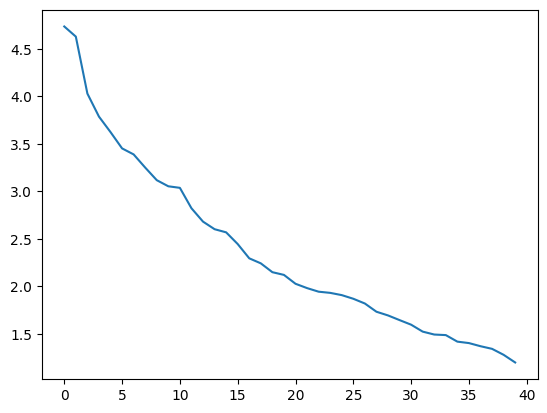

In [87]:
pca_fit.explained_variance_ratio_.cumsum()

# Plot curve
plt.plot(pca_fit.explained_variance_[:200])

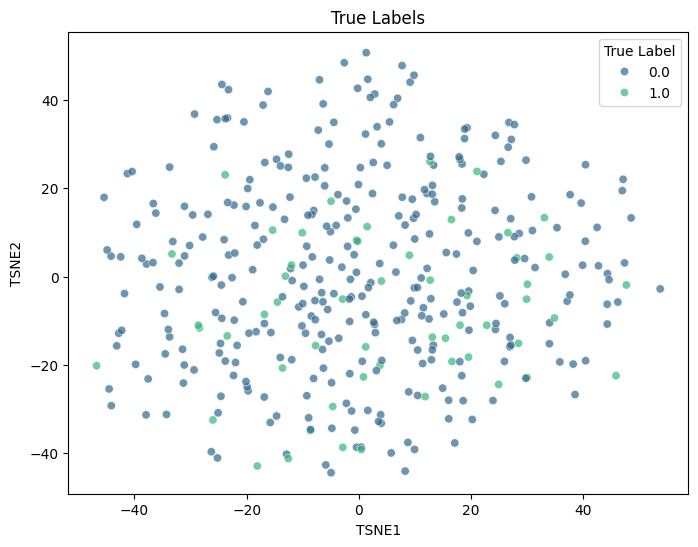

In [88]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# Reduce to 2D
tsne_3d = TSNE(n_components=3, perplexity=100)
features_3d = tsne_3d.fit_transform(features_reduced)

import seaborn as sns
import pandas as pd

# Create a DataFrame for easier plotting
df = pd.DataFrame({
    'TSNE1': features_3d[:, 0],
    'TSNE2': features_3d[:, 1],
    'TSNE3': features_3d[:, 2],
    'True Label': labels_np.squeeze(),
    'idx': range(len(features_3d)),
    'antenna': meta_data['antenna']
})

# Plot true labels
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='True Label', palette='viridis', alpha=0.7)
plt.title('True Labels')
plt.show()



In [89]:
import plotly.express as px
import plotly.io as pio

# Create 3D scatter plot with enhanced aesthetics
fig = px.scatter_3d(
    df,
    x='TSNE1',
    y='TSNE2',
    z='TSNE3',
    color='True Label',
    hover_data=['idx', 'antenna'],
    title='Enhanced 3D Scatter Plot',
    labels={
        'TSNE1': 't-SNE Component 1',
        'TSNE2': 't-SNE Component 2',
        'TSNE3': 't-SNE Component 3',
        'True Label': 'True Label',
    }
)

# Update marker properties for better aesthetics
fig.update_traces(
    marker=dict(
        size=5,          # Adjust marker size
        opacity=0.8,     # Set opacity for transparency
        symbol='circle', # Marker symbol
        line=dict(width=0.5, color='DarkSlateGrey')  # Border around markers
    )
)

# Customize the layout
fig.update_layout(
    scene=dict(
        xaxis=dict(title='t-SNE 1', backgroundcolor="rgb(200, 200, 230)"),
        yaxis=dict(title='t-SNE 2', backgroundcolor="rgb(230, 200,230)"),
        zaxis=dict(title='t-SNE 3', backgroundcolor="rgb(230, 230,200)"),
        camera=dict(
            eye=dict(x=1.25, y=1.25, z=1.25)  # Adjust camera angle
        )
    ),
    margin=dict(l=0, r=0, b=0, t=40),
    legend=dict(
        title='True Label',
        x=0.85,
        y=0.95
    )
)

# Optionally, adjust the background of the entire plot
fig.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white'
)

pio.write_html(fig, file="plot_3d_tsne.html")

In [177]:
meta_data['antenna'][774]

'ALASKA-HAARP_62'

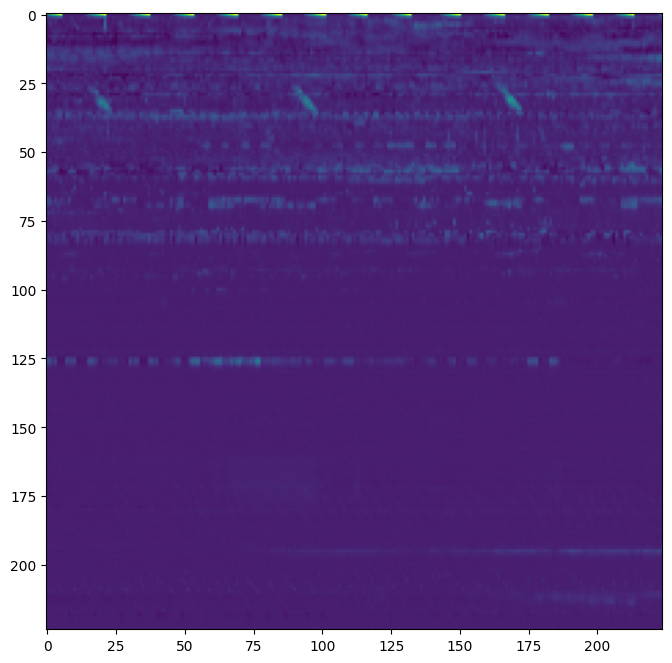

In [188]:
plt.figure(figsize=(8, 8))
plt.imshow(meta_data['image'][990].squeeze())

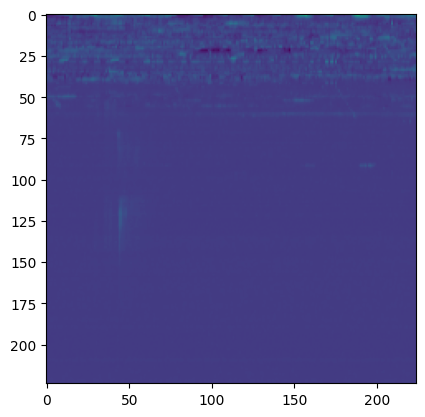

In [108]:
plt.imshow(meta_data['image'][5].squeeze())

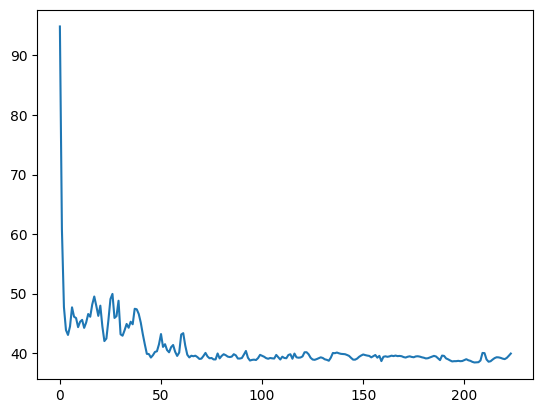

In [109]:
plt.plot(meta_data['image'][5].squeeze().sum(axis=1))

In [110]:
from scipy.stats import spearmanr

In [111]:
np.std(meta_data['image'][5].squeeze(), axis=1).std()

0.0239956

Axis 0: Über die Zeit 
Axis 1: Über die Frequenzen

In [112]:
meanstd = [np.std(x.squeeze(), axis=0).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], meanstd)

SignificanceResult(statistic=0.20990647296399273, pvalue=1.044379040345176e-17)

In [113]:
stdmax = [np.max(x.squeeze(), axis=0).std() for x in meta_data['image']]
spearmanr(features_2d[:, 0], stdmax)

SignificanceResult(statistic=-0.11633868334094884, pvalue=2.4498409293110275e-06)

In [114]:
maxmax = [np.max(x.squeeze(), axis=0).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], maxmax)

SignificanceResult(statistic=0.08209412286369833, pvalue=0.0009017778460311558)

In [115]:
minmin = [np.min(x.squeeze(), axis=1).mean() for x in meta_data['image']]
spearmanr(features_2d[:, 0], minmin)

SignificanceResult(statistic=0.003242692491844473, pvalue=0.89585573709995)

In [116]:
stdmin = [np.min(x.squeeze(), axis=1).std() for x in meta_data['image']]
spearmanr(features_2d[:, 0], stdmin)

SignificanceResult(statistic=0.12400561398312049, pvalue=5.030400469253062e-07)

In [117]:
sumsum = [np.sum(x.squeeze(), axis=0).sum() for x in meta_data['image']]
spearmanr(features_2d[:, 0], sumsum)

SignificanceResult(statistic=0.06989620289821206, pvalue=0.004728650197570081)

In [118]:
spearmanr(minmin, maxmax)

SignificanceResult(statistic=0.8787141970844197, pvalue=0.0)

In [119]:
spearmanr(stdstd, stdmax)

SignificanceResult(statistic=-0.7509184112501315, pvalue=5.013299601803183e-296)

In [120]:
spearmanr(stdstd, stdmin)

SignificanceResult(statistic=0.6511334065886156, pvalue=1.744259862863354e-197)

In [121]:
spearmanr(stdmax, stdmin)

SignificanceResult(statistic=-0.8416267364789375, pvalue=0.0)

In [122]:
spearmanr(stdstd, sumsum)

SignificanceResult(statistic=0.5777843161843634, pvalue=5.659937004485144e-146)

In [123]:
np.corrcoef(features_2d[:, 0], sum_intensity)

NameError: name 'sum_intensity' is not defined

In [171]:
meta_data['image'][0].shape

(1, 224, 224)

In [147]:
from sklearn.metrics import normalized_mutual_info_score

nmi = normalized_mutual_info_score(labels_np.squeeze(), cluster_labels)
print(f'Normalized Mutual Information: {nmi}')


Normalized Mutual Information: 0.21286951888571512
